이 교재의 AE 예제는 좀 별로인 것 같다.

In [2]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #맷플롯립에서 3차원 플롯을 그리는 용도
from matplotlib import cm               #cm 모듈은 데이터 포인트에 색상을 입히는데 사용
import numpy as np

In [4]:
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device : ", DEVICE)

Using Device :  cuda


In [5]:
train_set = datasets.FashionMNIST(
  root = '/content/drive/MyDrive/torch_tutorial/3min_torch/6ch_AE',
  train = True,
  download = True,
  transform = transforms.ToTensor(),
)

In [6]:
train_loader = torch.utils.data.DataLoader(
  dataset = train_set,
  batch_size = BATCH_SIZE,
  shuffle = True,
  num_workers = 2,
)

In [7]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(28 * 28, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 3),

    )
    self.decoder = nn.Sequential(
        nn.Linear(3, 16),
        nn.ReLU(),
        nn.Linear(16, 32),
        nn.ReLU(),
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 28 * 28),
        nn.Sigmoid(),
    )
    
  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [8]:
auto_encoder = AutoEncoder().to(DEVICE)
optimizer = torch.optim.Adam(auto_encoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [9]:
def add_noise(img):
  noise = torch.randn(img.size()) * 0.2
  noisy_img = img + noise
  return noisy_img

In [10]:
def train(auto_encoder, train_loader):
  auto_encoder.train()
  avg_loss = 0
  for step, (x, label) in enumerate(train_loader):
    noisy_x = add_noise(x)
    noisy_x = noisy_x.view(-1, 28 * 28).to(DEVICE)
    y = x.view(-1, 28 * 28).to(DEVICE) #정답군
    label = label.to(DEVICE)

    encoded, decoded = auto_encoder(noisy_x)

    loss = criterion(decoded, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    avg_loss += loss.item()
  return avg_loss / len(train_loader)

In [12]:
for epoch in range(1, EPOCH + 1):
  loss = train(auto_encoder, train_loader)
  print("[EPOCHS {} | LOSS {}]".format(epoch,loss))

[EPOCHS 1 | LOSS 0.02212085005944408]
[EPOCHS 2 | LOSS 0.022115867320837368]
[EPOCHS 3 | LOSS 0.02201784889636708]
[EPOCHS 4 | LOSS 0.02206044614132343]
[EPOCHS 5 | LOSS 0.021925642615807716]
[EPOCHS 6 | LOSS 0.021958255673697125]
[EPOCHS 7 | LOSS 0.02178137289530941]
[EPOCHS 8 | LOSS 0.02182401615038101]
[EPOCHS 9 | LOSS 0.021914427597592]
[EPOCHS 10 | LOSS 0.022235371239944055]


In [13]:
test_set = datasets.FashionMNIST(
  root = '/content/drive/MyDrive/torch_tutorial/3min_torch/6ch_AE',
  train = False,
  download = True,
  transform = transforms.ToTensor(),
)

In [19]:
sample_data = test_set.data[9].view(-1, 28 * 28)
sample_data = sample_data.type(torch.FloatTensor) / 255.

In [20]:
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = auto_encoder(noisy_x)

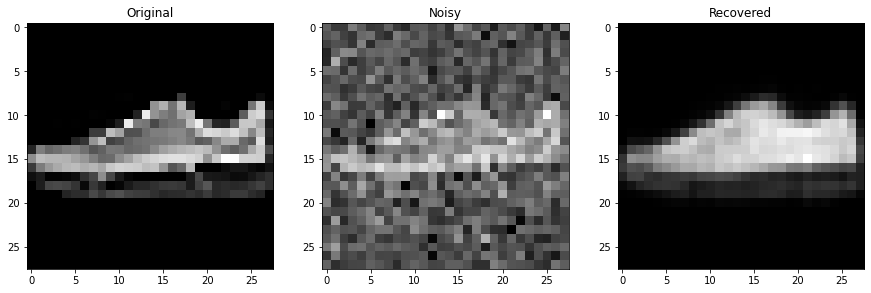

In [21]:
f, a = plt.subplots(1, 3, figsize = (15, 15))

#시각화를 위해 넘파이 행렬로 바꿔준다.
original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28,28))

#원본
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

#오염된 원본
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

#복원된 img
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()